# Importing all important libraries

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Creating special directories and collecting sample images using webcam 

In [4]:
POS_PATH=os.path.join('training','positive')
NEG_PATH = os.path.join ('training','negative')
FLAG_PATH = os.path.join('training','flag')

In [5]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(FLAG_PATH)

In [6]:
import uuid

In [7]:
#move lfw images to negative folder
for directory in os.listdir('lfw'):
   for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [21]:
cap = cv2.VideoCapture(0)#Establish a connection to the webcam
while cap.isOpened():
    ret,frame =cap.read()
    frame = frame[120:120+250,320:320+250,:]
    #collect anchors
    if cv2.waitKey(1) & 0XFF==ord('f'):
        imgname = os.path.join(FLAG_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    #collect positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
        
    
    cv2.imshow('Image Collection',frame)
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
#release webcam
cap.release()
cv2.destroyAllWindows()

In [12]:
from shutil import move

# Shuffling all images in respective directories

In [22]:
import os
import random
from shutil import move

POS_PATH = os.path.join('training', 'positive')

def shuffle_images(directory_path):
    # Step 1: List images in the directory
    image_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Step 2: Shuffle the list of image files
    random.shuffle(image_files)

    # Step 3: Rename and move the shuffled images
    for i, old_name in enumerate(image_files):
        new_name = f"shuffled_{i + 1}.jpg"  # Rename as needed
        old_path = os.path.join(directory_path, old_name)
        new_path = os.path.join(directory_path, new_name)
        move(old_path, new_path)

# Shuffle images in the POS_PATH directory
shuffle_images(POS_PATH)


    

In [20]:
FLAG_PATH = os.path.join('training', 'flag')

def shuffle_images(directory_path):
    # Step 1: List images in the directory
    image_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Step 2: Shuffle the list of image files
    random.shuffle(image_files)

    # Step 3: Rename and move the shuffled images
    for i, old_name in enumerate(image_files):
        new_name = f"rearranged_{i + 1}.jpg"  # Rename as needed
        old_path = os.path.join(directory_path, old_name)
        new_path = os.path.join(directory_path, new_name)
        move(old_path, new_path)

# Shuffle images in the POS_PATH directory
shuffle_images(FLAG_PATH)

# Taking 450 images from each directory for training

In [23]:
flag =tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(450)
positive =tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(450)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(450)

In [25]:
dir_test=flag.as_numpy_iterator()


# Defining the image preprocessing function

In [40]:
def preprocess(file_path):
    #Read in image from file path
    byte_img=tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    #Preprocessing steps 
    img = tf.image.resize(img,(105,105))
    img=img/255.0
    return img

In [41]:
positives= tf.data.Dataset.zip((flag,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(flag)))))
negatives = tf.data.Dataset.zip((flag,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(flag)))))
data = positives.concatenate(negatives)

In [42]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [43]:
sample =data.as_numpy_iterator().next()

In [44]:
res=preprocess_twin(*sample)

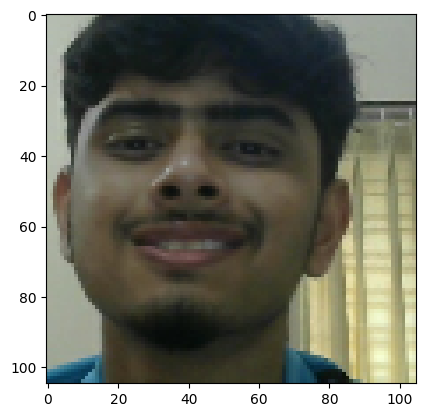

In [45]:
plt.imshow(res[1])

In [46]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024) 


In [47]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

# splitting the images into training and testing dataset

In [48]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [49]:
# Calculate the number of samples to skip and take
skip_count = int(round(len(data) * 0.7))
take_count = int(round(len(data) * 0.3))

# Create the testing dataset
test_data = data.skip(skip_count)
test_data = test_data.take(take_count)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


# Building the Convolutional Neural Network

In [51]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

def make_embedding():
    inp = Input(shape=(105, 105, 3), name='input_image')

    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    c1 = BatchNormalization()(c1)
    m1 = MaxPooling2D((2, 2), padding='same')(c1)

    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    c2 = BatchNormalization()(c2)
    m2 = MaxPooling2D((2, 2), padding='same')(c2)

    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    c3 = BatchNormalization()(c3)
    m3 = MaxPooling2D((2, 2), padding='same')(c3)

    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    c4 = BatchNormalization()(c4)
    m4 = MaxPooling2D((2, 2), padding='same')(c4)

    f1 = Flatten()(m4)
    d1 = Dense(4096, activation='relu')(f1)
    d1 = Dropout(0.5)(d1)  # Adding Dropout for regularization

    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [52]:
embedding= make_embedding()

In [53]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 batch_normalization (Batch  (None, 96, 96, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 batch_normalization_1 (Bat  (None, 42, 42, 128)       51

In [54]:
class Dist_Layer(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    def call(self,input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [55]:
l1=Dist_Layer()

In [56]:
l1

In [78]:
def make_recognition_model():
    #Anchor image network
    input_image = Input(name='input_img', shape=(105,105,3))
    #validation image
    validation_image = Input(name='validation_img',shape=(105,105,3))
    #combine
    siamese_layer=Dist_Layer()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    #Classification
    classifier = Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_image,validation_image],outputs=classifier, name='FACEID')

In [79]:
recognition_model = make_recognition_model()

In [80]:
recognition_model.summary()

Model: "FACEID"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 1065120   ['input_img[0][0]',           
                                                          0          'validation_img[0][0]']      
                                                                                             

In [76]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [77]:
opt  = tf.keras.optimizers.Adam(1e-4)

In [81]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir , 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,recognition_model = recognition_model)

In [83]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = recognition_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, recognition_model.trainable_variables)
    opt.apply_gradients(zip(grad, recognition_model.trainable_variables))
    return loss


# Building the training function

In [84]:
def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        if epoch %10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [85]:
train(train_data, 50)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
40/40 [==============================] - 41s 909ms/step

 Epoch 2/50
40/40 [==============================] - 35s 867ms/step

 Epoch 3/50
40/40 [==============================] - 34s 837ms/step

 Epoch 4/50
40/40 [==============================] - 34s 850ms/step

 Epoch 5/50
40/40 [==============================] - 41s 1s/step

 Epoch 6/50
40/40 [==============================] - 38s 944ms/step

 Epoch 7/50
40/40 [==============================] - 36s 899ms/step

 Epoch 8/50
40/40 [==============================] - 34s 862ms/step

 Epoch 9/50
40/40 [==============================] - 34s 844ms/step

 Epoch 10/50
40/40 [==============================] - 38s 959ms/step

 Epoch 11/50
40/40 [==============================] - 38s 958ms/step

 Epoch 12/50
40/40 [==============================] - 34s 849ms/step

 Epoch 13/50
40/4

In [66]:
from tensorflow.keras.metrics import Precision, Recall

In [67]:
test_input,test_val,y_true = test_data.as_numpy_iterator().next()

In [68]:
test_var=test_data.as_numpy_iterator().next()

In [69]:
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[4.8639907e-12],
       [9.9971056e-01],
       [3.1161330e-15],
       [2.6317647e-16],
       [2.1564957e-14],
       [9.9999666e-01],
       [1.2355824e-18],
       [1.6708384e-21],
       [9.9992394e-01],
       [4.8269185e-13],
       [9.9997503e-01],
       [4.2296526e-22],
       [1.0000000e+00],
       [3.1120899e-14],
       [1.0000000e+00],
       [9.9999988e-01]], dtype=float32)

# Saving the model

In [86]:
recognition_model.save('facialverification.h5')

C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
model =tf.keras.models.load_model('facialverification.h5',custom_objects={'Dist_Layer':Dist_Layer,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [88]:
model.predict([test_input,test_val])

1/1 [==============================] - 6s 6s/step


array([[4.1834438e-27],
       [9.9936414e-01],
       [7.2150219e-16],
       [8.4781229e-23],
       [1.0825421e-21],
       [9.9999464e-01],
       [3.1787411e-25],
       [1.4926790e-05],
       [9.9997443e-01],
       [3.3870642e-14],
       [9.9955869e-01],
       [1.3622645e-27],
       [9.9992347e-01],
       [5.3141441e-15],
       [1.0000000e+00],
       [9.9996179e-01]], dtype=float32)

In [89]:
valid_path = os.path.join('application_data','verification_images')

In [97]:
def verify(model,detection_threshold,verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img= preprocess(os.path.join('application_data','input_images','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))
        result = model.predict(list(np.expand_dims([input_img,validation_img],axis =1)))
        results.append(result)
        detection = np.sum(np.array(results)>detection_threshold)
        verification = detection/len(os.listdir(os.path.join('application_data','verification_images')))
        verified = verification>verification_threshold
    return results, verified

# Real Time testing

In [ ]:
from matplotlib.pyplot import imshow
cap =cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame =cap.read()
    frame = frame[120:120+250,320:320+250,:]
    cv2.imshow('verification',frame)
    if cv2.waitKey(10) & 0xFF==ord('v'):
        cv2.imwrite(os.path.join('application_data','input_images','input_image.jpg'),frame)
        imshow(frame)
        results,verified = verify(model,0.9,0.7)
        print(verified)
        print('. ')
        if (verified == True):
            print('Face verified')
        else:
            print('Not verified')
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 62ms/step
True
. 
Face verified
1/1 [==============================] - 0s 177ms/step
False
. 
Not verified
1/1 [==============================] - 0s 56ms/step
True
. 
Face verified
1/1 [==============================] - 0s 62ms/step
False
. 
Not verified
